In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from PIL import Image
import sys

# Utilizando os comandos abaixo para baixar o conjunto de dados do problema

In [ ]:
!pip install gdown unrar
!gdown https://drive.google.com/u/0/uc?id=1-R2tYoDl_P56LevfF95tP_qv1MbcVZQJ
!gdown https://drive.google.com/uc?id=13zpbNNGYafdYWmdQO0-ArGjm9ipZkD5Q
!ls
!unrar x data_folder.rar

Streaming output truncated to the last 5000 lines.
Extracting  data_folder/6929597574_dc5dd8b10b.jpg                         60%  OK 
Extracting  data_folder/6931532444_f3f1db0b6e.jpg                         60%  OK 
Extracting  data_folder/6938682540_7697a17902.jpg                         60%  OK 
Extracting  data_folder/6938683414_07c2935433.jpg                         60%  OK 
Extracting  data_folder/6938684226_d38a72c32d.jpg                         60%  OK 
Extracting  data_folder/6938688566_4a72e848f7.jpg                         60%  OK 
Extracting  data_folder/6938696766_abb5dd7907.jpg                         60%  OK 
Extracting  data_folder/6938697544_ea0a40b970.jpg                         60%  OK 
Extracting  data_folder/6938704602_024838879c.jpg                         60%  OK 
Extracting  data_folder/6938705546_816070e2b8.jpg                         60%  OK 
Extracting  data_folder/69387

# Começando a ler os arquivos

Com os arquivos já baixados, lemos o arquivo dataset_images_minitest.csv, já que ele é o arquivo que contém o nome de todas as imagens, assim como a resposta (label) de suas respectivas categorias. 
Além disso, embaralhei os dados com o comando random.shuffle, já que nesse arquivo, as imagens da mesma categoria estavam em sequência, o que é prejudicial para o treinamento da rede.
Atribuí a cada categoria (temos 3) um valor de 0 a 2.

In [ ]:
dat = pd.read_csv('dataset_images_minitest.csv', delimiter = '\t')


dat = np.array(dat)

np.random.shuffle(dat)

for i in range(len(dat)):
    if dat[i,1] == 'picnic':
        dat[i,1] = 0
    elif dat[i,1] == 'graduation':
        dat[i,1] = 1
    elif dat[i,1] == 'meeting':
        dat[i,1] = 2

print(dat)

[['3059580827_4cb2c95314.jpg' 0]
 ['5416336519_8c38bb42c1.jpg' 2]
 ['4525450206_c14e11b33a.jpg' 0]
 ...
 ['20353808870_0dc1f991fd.jpg' 2]
 ['13544795044_73bfa2a5dc.jpg' 2]
 ['26684207_d0a2a67e33.jpg' 0]]


In [ ]:
labels = dat[:,1]

# Lendo as imagens a partir dos nomes fornecidos no csv

Li as imagens a partir dos nomes fornecidos no csv e mudei a resolução das mesmas. Esse processo foi necessário para que a variável images puesse ser armazenada na RAM disponível.
O problema podia ser resolvido sem mudar a resolução da imagem se a rede fosse treinada com batches menores, atribuindo à variavel "images" conjuntos menores de images a cada vez que a rede fosse ser treinada. 

In [ ]:
images = []

for i in range(len(dat)):

  img = Image.open("data_folder/" + dat[i][0]).convert('L')
  img = img.resize((100,100))

  images.append(np.array(img))

In [ ]:
images = np.expand_dims(np.asarray(images), axis = 3)/255

In [ ]:
train_images = images[:np.int(0.8*len(images))]/255.
train_labels = dat[:np.int(0.8*len(dat[:,1])),1]

test_images = images[np.int(0.8*len(images)):]/255.
test_labels = dat[np.int(0.8*len(dat[:,1])):,1]

train_images = np.expand_dims(train_images, axis = 3)
test_images = np.expand_dims(test_images, axis = 3)

Exemplo da rede que pode ser rodada fora do k-fold para testar se o programa tem algum erro na escrita e se a rede apresenta resultados satisfatórios. Isso foi importante no desenvolvimento do código porque o k-fold demandava muito mais tempo, então testar as pequenas modificações do código fora do loop foi uma maneira muita mais prática de avaliar se as mudanças eram pertinentes ou não.

In [ ]:
network = Sequential([
                  Conv2D(64, 3, input_shape = (100,100,1)),
                  Conv2D(32, 3),
                  MaxPooling2D(pool_size = 2),
                  Dropout(0.4),
                  Conv2D(32, 3),
                  MaxPooling2D(pool_size = 2),
                  Dropout(0.3),
                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dense(64, activation = 'relu'),
                  #Dropout(0.2),
                  Dense(3, activation = 'softmax'),
                             ])

In [ ]:
network.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])

In [ ]:
network.fit(train_images, 
            to_categorical(train_labels), 
            epochs = 5, 
            batch_size = 32)

Epoch 1/5
525/525 [==============================] - 11s 21ms/step - loss: 1.0078 - accuracy: 0.4984
Epoch 2/5
525/525 [==============================] - 11s 21ms/step - loss: 0.8977 - accuracy: 0.5851
Epoch 3/5
525/525 [==============================] - 11s 21ms/step - loss: 0.8080 - accuracy: 0.6453
Epoch 4/5
525/525 [==============================] - 11s 21ms/step - loss: 0.6996 - accuracy: 0.7000
Epoch 5/5
525/525 [==============================] - 11s 22ms/step - loss: 0.5472 - accuracy: 0.7754


In [ ]:
test_loss, test_acc = network.evaluate(test_images, to_categorical(test_labels))

132/132 [==============================] - 1s 8ms/step - loss: 1.3635 - accuracy: 0.5364


# Inicio do teste K-Fold

Começo inicializando listas vazias nas quais vou armazenar os valores encontrados no loop do teste.

In [ ]:
loss = []
val_loss = []
acc = []
val_acc = []

epoch_vec = []

In [ ]:
images = np.array(np.array_split(images, 5))
dat = np.array(np.array_split(dat[:,1],5))

#Loop do teste

O número que aparece no range (no caso deste notebook, o número 5) define quantos folds serão feitos.

Note que a cada iteração, a rede é compilada novamente. Isso pode ser feito de outra maneira mais elegante, por meio de um comando que reinicie os pesos da rede.

In [ ]:
for i in range(5):
  network = Sequential([
                  Conv2D(64, 3, input_shape = (100,100,1)),
                  MaxPooling2D(pool_size = 2),
                  Dropout(0.4),
                  Conv2D(32, 3),
                  MaxPooling2D(pool_size = 2),
                  Dropout(0.4),
                  Conv2D(32, 3),
                  MaxPooling2D(pool_size = 2),
                  Dropout(0.3),
                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dense(64, activation = 'relu'),
                  #Dropout(0.2),
                  Dense(3, activation = 'softmax'),
                             ])
  
  network.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  
  train_images = np.concatenate(np.array([x for j,x in enumerate(images) if j!=i]))
  train_labels = np.concatenate(np.array([x for j,x in enumerate(dat) if j!=i]))

  test_images = images[i]
  test_labels = dat[i]

  history = network.fit(train_images, 
            to_categorical(train_labels), 
            epochs = 20, 
            batch_size = 128, 
            validation_data = (
                test_images,
                to_categorical(test_labels)
            ))

  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])

  epoch_vec.append(range(1, len(acc[i]) + 1))

Epoch 1/20
132/132 [==============================] - 6s 47ms/step - loss: 1.0363 - accuracy: 0.4611 - val_loss: 1.0405 - val_accuracy: 0.4702
Epoch 2/20
132/132 [==============================] - 6s 44ms/step - loss: 0.9538 - accuracy: 0.5502 - val_loss: 0.9891 - val_accuracy: 0.5291
Epoch 3/20
132/132 [==============================] - 6s 44ms/step - loss: 0.9096 - accuracy: 0.5845 - val_loss: 1.1800 - val_accuracy: 0.4578
Epoch 4/20
132/132 [==============================] - 6s 44ms/step - loss: 0.8882 - accuracy: 0.5935 - val_loss: 0.9332 - val_accuracy: 0.5607
Epoch 5/20
132/132 [==============================] - 6s 44ms/step - loss: 0.8545 - accuracy: 0.6182 - val_loss: 1.0719 - val_accuracy: 0.5219
Epoch 6/20
132/132 [==============================] - 6s 45ms/step - loss: 0.8236 - accuracy: 0.6329 - val_loss: 1.0100 - val_accuracy: 0.5586
Epoch 7/20
132/132 [==============================] - 6s 45ms/step - loss: 0.7951 - accuracy: 0.6524 - val_loss: 1.0440 - val_accuracy: 0.5400

In [ ]:
epoch_vec = []
for i in range(5):
  epoch_vec.append(np.arange(1, len(acc[i]) + 1))

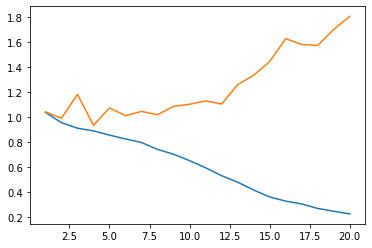

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_vec[0], loss[0])
plt.plot(epoch_vec[0], val_loss[0])

In [ ]:
loss = np.array(loss)
val_loss = np.array(val_loss)
acc = np.array(acc)
val_acc = np.array(val_acc)

In [ ]:
loss_std = np.std(loss, axis = 0)
val_loss_std = np.std(val_loss, axis = 0)
acc_std = np.std(acc, axis = 0)
val_acc_std = np.std(val_acc, axis = 0)

loss = np.average(loss,axis = 0)
val_loss = np.average(val_loss, axis = 0)
acc = np.average(acc, axis = 0)
val_acc = np.average(val_acc, axis = 0)



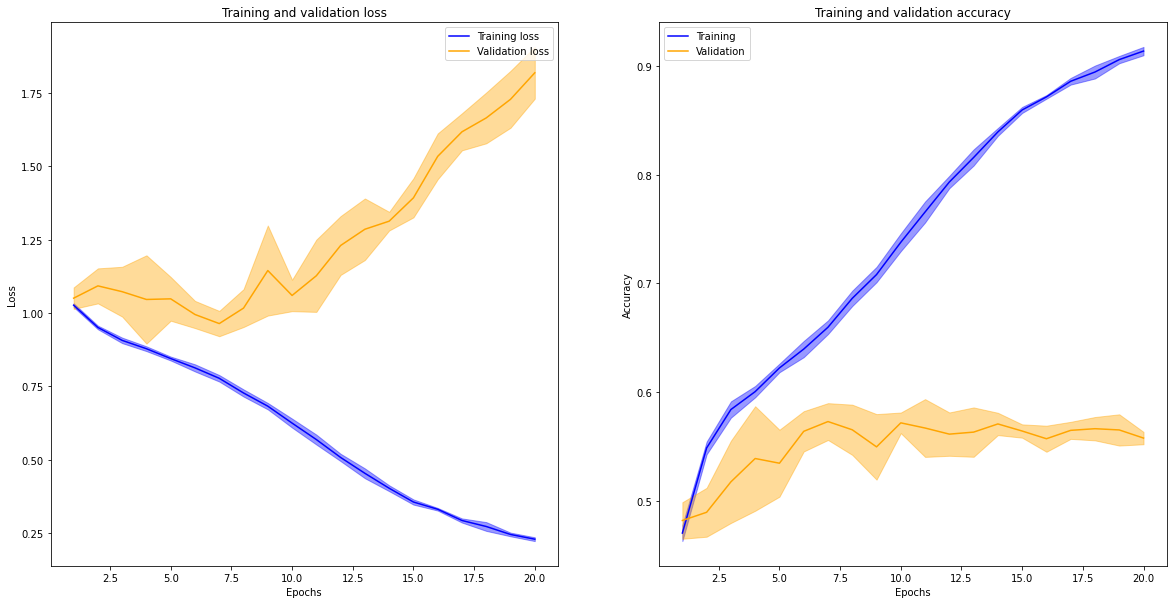

In [ ]:
max_fit_loss = loss + loss_std
min_fit_loss = loss - loss_std
max_fit_acc = acc + acc_std
min_fit_acc = acc - acc_std

max_val_loss = val_loss + val_loss_std
min_val_loss = val_loss - val_loss_std
max_val_acc = val_acc + val_acc_std
min_val_acc = val_acc - val_acc_std

plt.figure(figsize=(20,10))
plt.subplot(121)
# "bo" is for "blue dot"
plt.plot(epoch_vec[0], loss, label='Training loss', color = 'blue')
# b is for "solid blue line"
plt.plot(epoch_vec[0], val_loss, label='Validation loss', color = 'orange')
plt.fill_between(epoch_vec[0], max_fit_loss, min_fit_loss, color = 'blue', alpha = 0.4)
plt.fill_between(epoch_vec[0], max_val_loss, min_val_loss, color = 'orange', alpha = 0.4)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epoch_vec[0], acc, label='Training', color = 'blue')
plt.plot(epoch_vec[0], val_acc, label='Validation', color = 'orange')
plt.fill_between(epoch_vec[0], max_fit_acc, min_fit_acc, color = 'blue', alpha = 0.4)
plt.fill_between(epoch_vec[0], max_val_acc, min_val_acc, color = 'orange', alpha = 0.4)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()